# Azure AI Search with Azure AI Vision multimodal embeddings for text-to-image and image-to-image queries

As a scenario, this code shows you an approach for text-to-image and image-to-image vector queries. The multimodal embeddings used in this sample are provided by [Azure AI Vision 4.0](https://learn.microsoft.com/azure/ai-services/computer-vision/how-to/image-retrieval) and the [Image Retrieval REST API](https://learn.microsoft.com/rest/api/computervision/image-retrieval) which supports built-in vectorization of images. 

For indexing, the pattern uses the built in Vision Vectorizer skill to call the Image Retrieval API. Provisioning of this search service, AI Services account, and setup of the indexer is fully automated and included as a step in this notebook.

The AI services accounts is also used during queries, as the vectorizer. A vectorizer specifies which embedding model to use for vectorizing a text query string or an images. As always, it's strongly recommended that query vectorization is performed using the same embedding model used for document vectorization during indexing.

### Prerequisites

+ [Azure AI Search](https://learn.microsoft.com/azure/search/search-create-service-portal), any region and tier, but we recommend Basic or higher for this workload.

+ [Azure Blob storage](https://learn.microsoft.com/azure/storage/common/storage-account-create), used as the data source during indexing.

+ [Azure AI Services](https://learn.microsoft.com/azure/ai-services/multi-service-resource), used for multi-modal embeddings.

+ [azd](https://learn.microsoft.com/azure/developer/azure-developer-cli/install-azd), used to deploy an Azure function app and Azure AI SErvices in your Azure subscription.

We use the [Azure Python SDK](https://learn.microsoft.com/en-us/python/api/azure-search-documents/?view=azure-python-preview) for indexer-driven indexing and vector query operations.

### Set up a Python virtual environment in Visual Studio Code

1. Open the Command Palette (Ctrl+Shift+P).
1. Search for **Python: Create Environment**.
1. Select **Venv**.
1. Select a Python interpreter. Choose 3.10 or later.

It can take a minute to set up. If you run into problems, see [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

### Install packages

In [1]:
! pip install -r multimodal-embeddings-requirements.txt --quiet

### Provision the sample

This sample uses [`azd`](https://learn.microsoft.com/azure/developer/azure-developer-cli/), a bicep template, and a custom post-provision hook to provision the sample. The sample uses role-based authentication using your identity for authentication, and does not use any API keys.

1. Open a PowerShell command prompt in the multimodal-embeddings folder.

1. Run `azd config set defaults.subscription <yourSubscriptionID>` to set the subscription if you have multiple Azure subscriptions.
1. Run `azd env new <your-environment-name>` to create an environment for deploying the sample.
1. If you want to use an existing resource, set the corresponding `azd` environment variables before deployment:
   1. Existing Search resource:
      1. `azd env set AZURE_SEARCH_SERVICE <your-search-service-name>`
      1. `azd env set AZURE_SEARCH_SERVICE_LOCATION <your-search-service-location>`
      1. `azd env set AZURE_SEARCH_SERVICE_RESOURCE_GROUP <your-search-service-resource-group>`
      1. `azd env set AZURE_SEARCH_SERVICE_SKU <your-search-service-sku>`
      1. `azd env set AZURE_SEARCH_SERVICE_SEMANTIC_RANKER <your-semantic-ranker-sku>`
   1. Existing AI Services resource:
      1. `azd env set AZURE_AI_SERVICES_ACCOUNT <your-ai-services-account-name>`
      1. `azd env set AZURE_AI_SERVICES_LOCATION <your-ai-services-account-location>`
      1. `azd env set AZURE_AI_SERVICES_RESOURCE_GROUP <your-ai-services-resource-group>`
   1. Existing Storage resource:
      1. `azd env set AZURE_STORAGE_ACCOUNT <your-storage-account-name>`
      1. `azd env set AZURE_STORAGE_ACCOUNT_LOCATION <your-storage-account-location>`
      1. `azd env set AZURE_STORAGE_ACCOUNT_RESOURCE_GROUP <your-storage-account-resource-group>`
1. Run `azd provision`.
   1. Enter a region for the sample deployment. Choose a region that provides the Image Retrieval API: `East US`, `France Central`, `Korea Central`, `North Europe`, `Southeast Asia`, `West Europe`, `West US`.

This step takes several minutes to complete.

### Retrieve environment variables after provisioning

The included `azd` bicep template saves all required environment variables for the notebook automatically.

In [2]:
# Load all environment variables from the azd deployment
import subprocess
from io import StringIO
from dotenv import load_dotenv
import os
result = subprocess.run("azd env get-values", stdout=subprocess.PIPE, cwd=os.getcwd())
load_dotenv(override=True, stream=StringIO(result.stdout.decode("utf-8")))

True

## Validate the indexer has completed successfully

An indexer created in [scripts/setup.py](./scripts/setup.py) runs in the background to process all the sample images. Validate that it has completed without any errors before trying to search the sample index. It's possible the indexer may fail due to being throttled by the image embeddings from AI Services. If this is the case, try rerunning the indexer to resolve the issue.

In [7]:
from azure.search.documents.indexes import SearchIndexerClient
from azure.identity import DefaultAzureCredential

search_indexer_client = SearchIndexerClient(endpoint=os.getenv("AZURE_SEARCH_ENDPOINT"), credential=DefaultAzureCredential())
status = search_indexer_client.get_indexer_status(name=os.getenv("AZURE_SEARCH_INDEXER"))
print(f"Status: {status.last_result.status}, Items Processed: {status.last_result.item_count}, Items Failed: {status.last_result.failed_item_count}")

Status: success, Items Processed: 11, Items Failed: 0


### Perform a vector search by vectorizing your text query

Perform a vector search to find the most relevant images based on the text query.

Vector queries call [VectorizableTextQuery](https://learn.microsoft.com/python/api/azure-search-documents/azure.search.documents.models.vectorizabletextquery) to vectorize a query text string that's used to match against vectorized images created by AI Services. VectorizeableTextQuery uses the vectorizer defined in the index, which is Azure AI Vision image retrieval.

Image: GrannySmith.jpeg


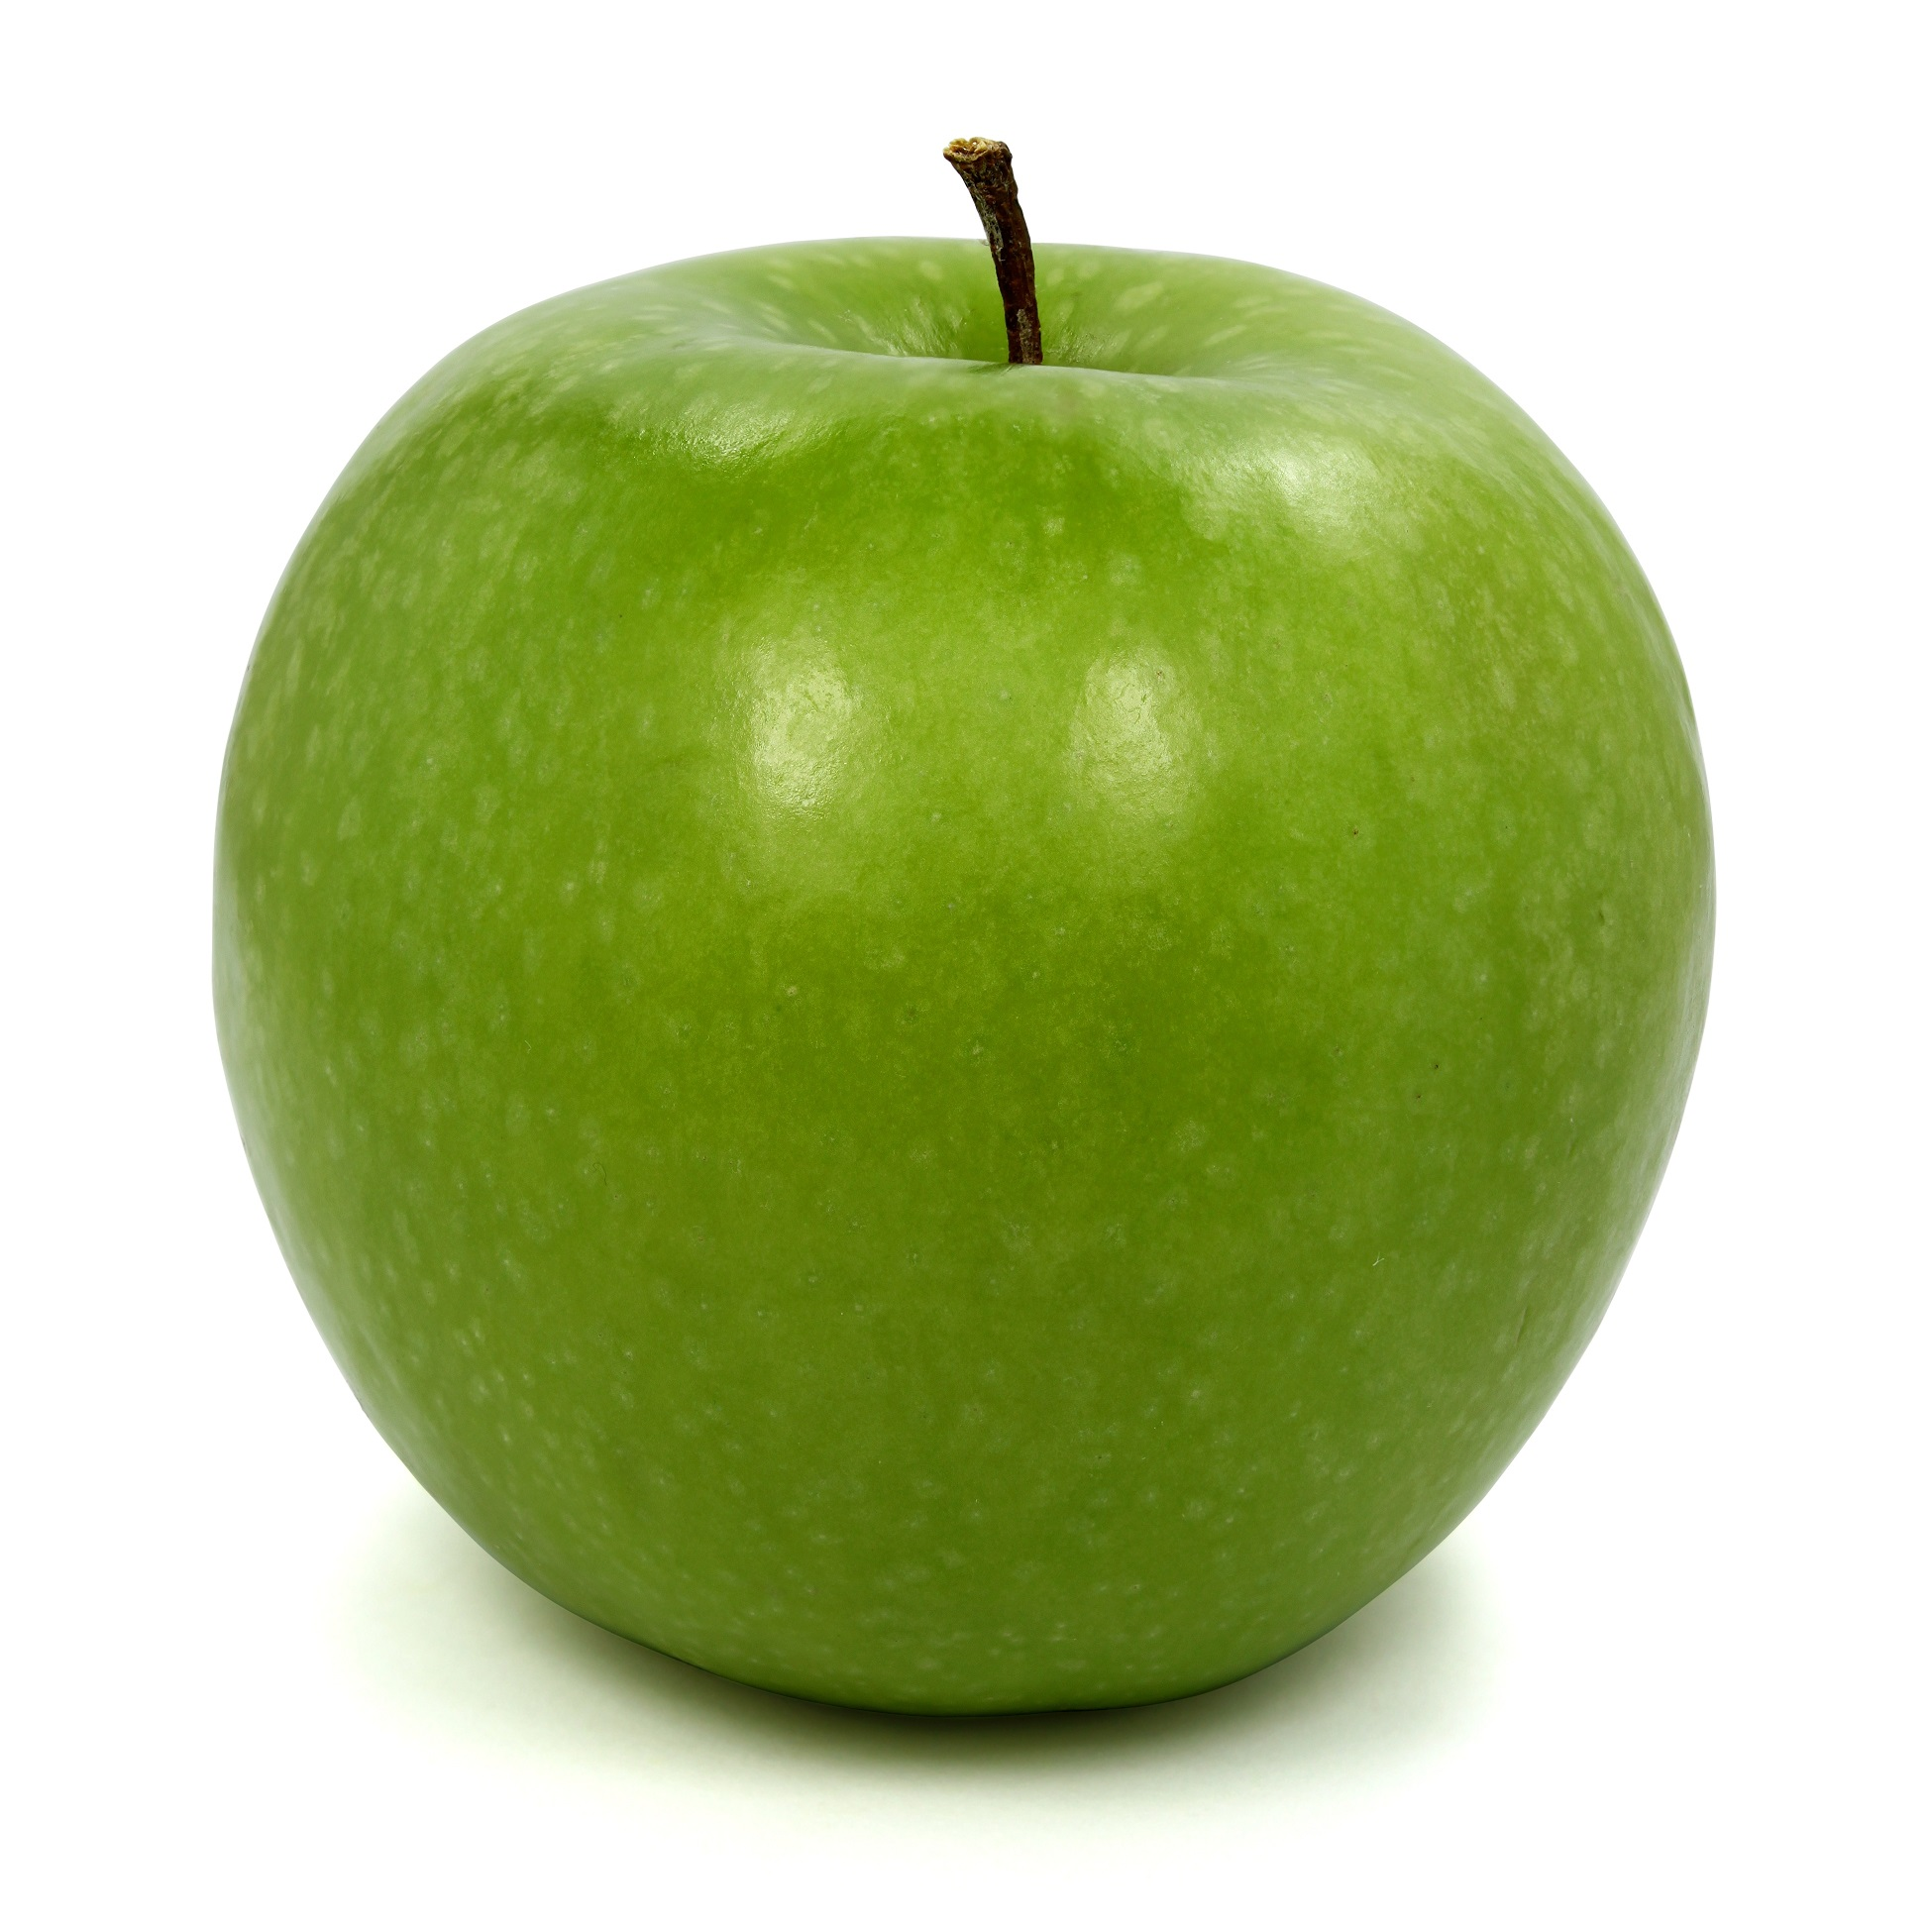

In [4]:
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizableTextQuery
from IPython.display import Image

apples_image_directory = os.path.join('..', '..', '..', 'data', 'images', 'apples')
# Generate text embeddings for the query  
query = "green apple"  
  
# Initialize the SearchClient  
search_client = SearchClient(endpoint=os.getenv("AZURE_SEARCH_ENDPOINT"), index_name=os.getenv("AZURE_SEARCH_INDEX"), credential=DefaultAzureCredential())  
vector_query = VectorizableTextQuery(text=query, k_nearest_neighbors=1, fields="embedding")  

# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["metadata_storage_path"],
    top=1
)   
  
# Print the search results  
for result in results:  
    print(f"Image: {os.path.basename(result['metadata_storage_path'])}") 
    display(Image(filename=os.path.join(apples_image_directory, os.path.basename(result['metadata_storage_path'])))) 
    print("\n") 


### Perform a vector search by vectorizing your image query from a URL

Perform a vector search to find the most relevant images based on the image query.

Vector queries call [VectorizableImageUrlQuery](https://learn.microsoft.com/python/api/azure-search-documents/azure.search.documents.models.vectorizableimageurlquery?view=azure-python-preview) to vectorize a query image from a URL that's used to match against vectorized images created by AI Services. VectorizableImageUrlQuery uses the vectorizer defined in the index, which is Azure AI Vision image retrieval.

Source Image


Image: Honeycrisp.jpeg


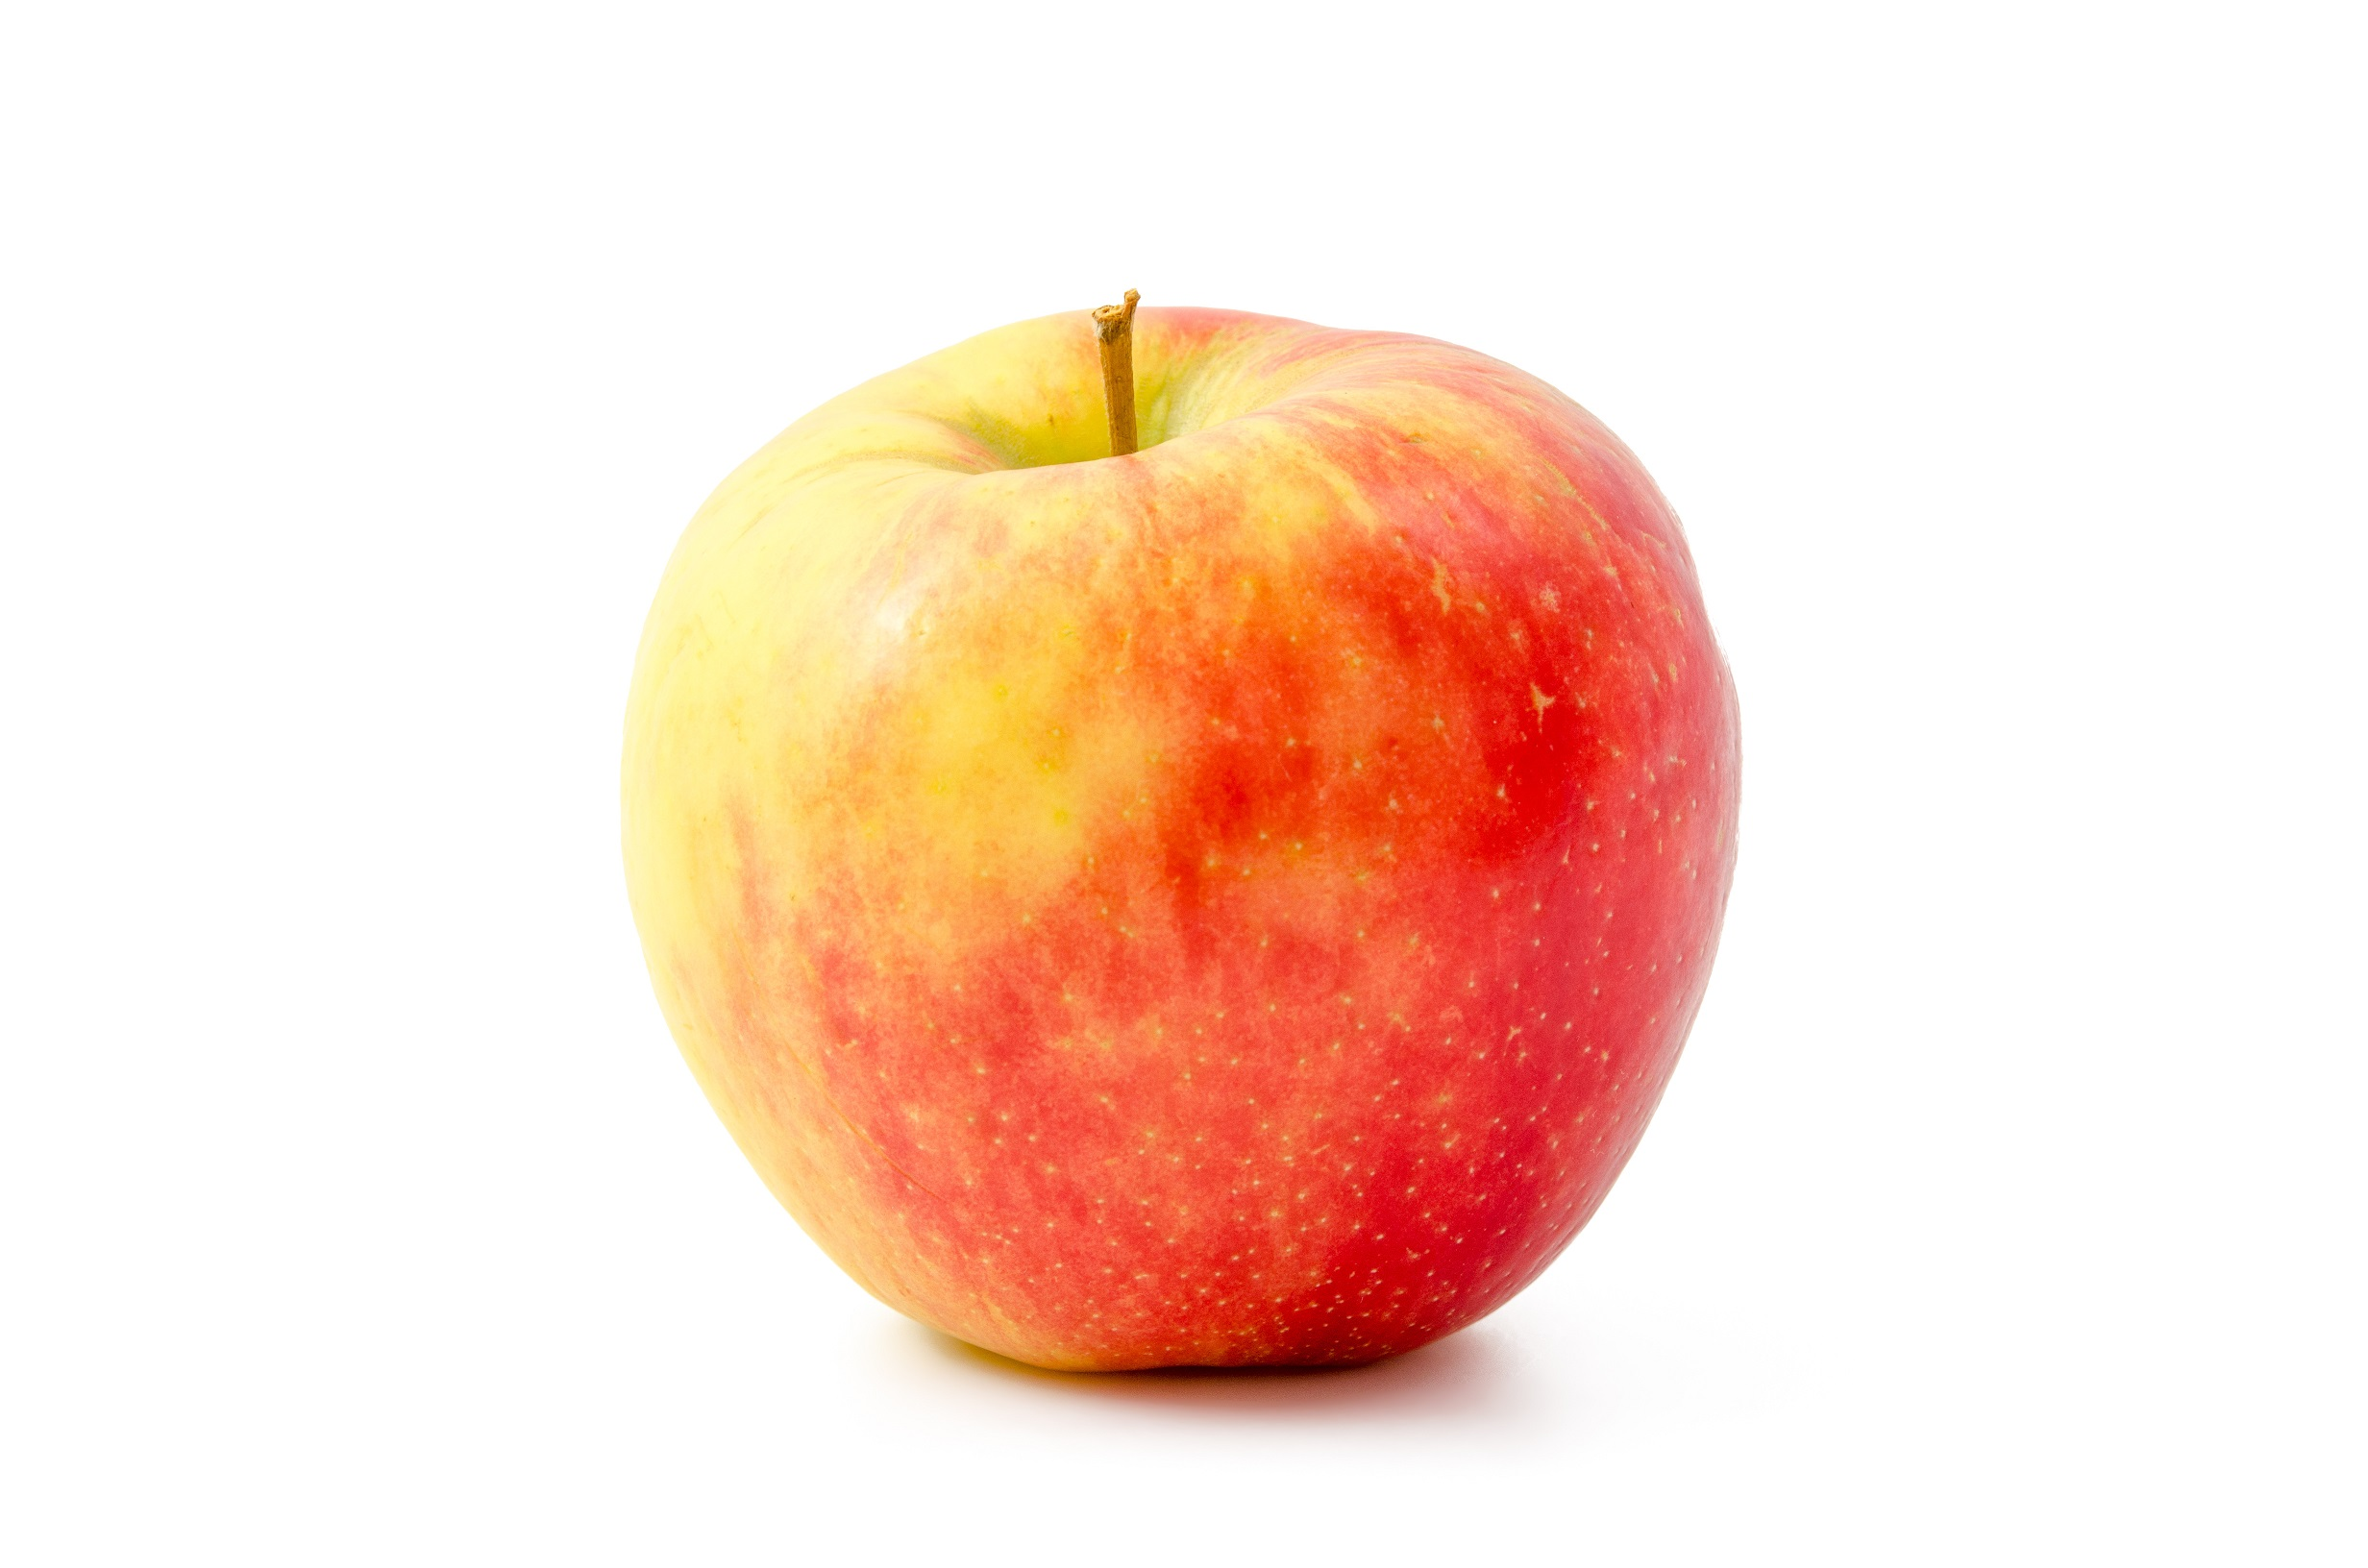

In [5]:
from azure.search.documents.models import VectorizableImageUrlQuery

url = "https://upload.wikimedia.org/wikipedia/commons/a/a6/Pink_lady_and_cross_section.jpg"
vector_query = VectorizableImageUrlQuery(url=url, k_nearest_neighbors=1, fields="embedding")  

# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["metadata_storage_path"],
    top=1
)   
  
print("Source Image")
display(Image(url=url))
# Print the search results  
for result in results:  
    print(f"Image: {os.path.basename(result['metadata_storage_path'])}") 
    display(Image(filename=os.path.join(apples_image_directory, os.path.basename(result['metadata_storage_path'])))) 
    print("\n") 

### Perform a vector search by vectorizing your image query from a file

Perform a vector search to find the most relevant images based on the image query.

Vector queries call [VectorizableImageBinaryQuery](https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.models.vectorizableimagebinaryquery?view=azure-python-preview) to vectorize a query image from a file that's used to match against vectorized images created by AI Services. VectorizableImageBinaryQuery uses the vectorizer defined in the index, which is Azure AI Vision image retrieval.

Source Image


Image: Fiji.jpeg


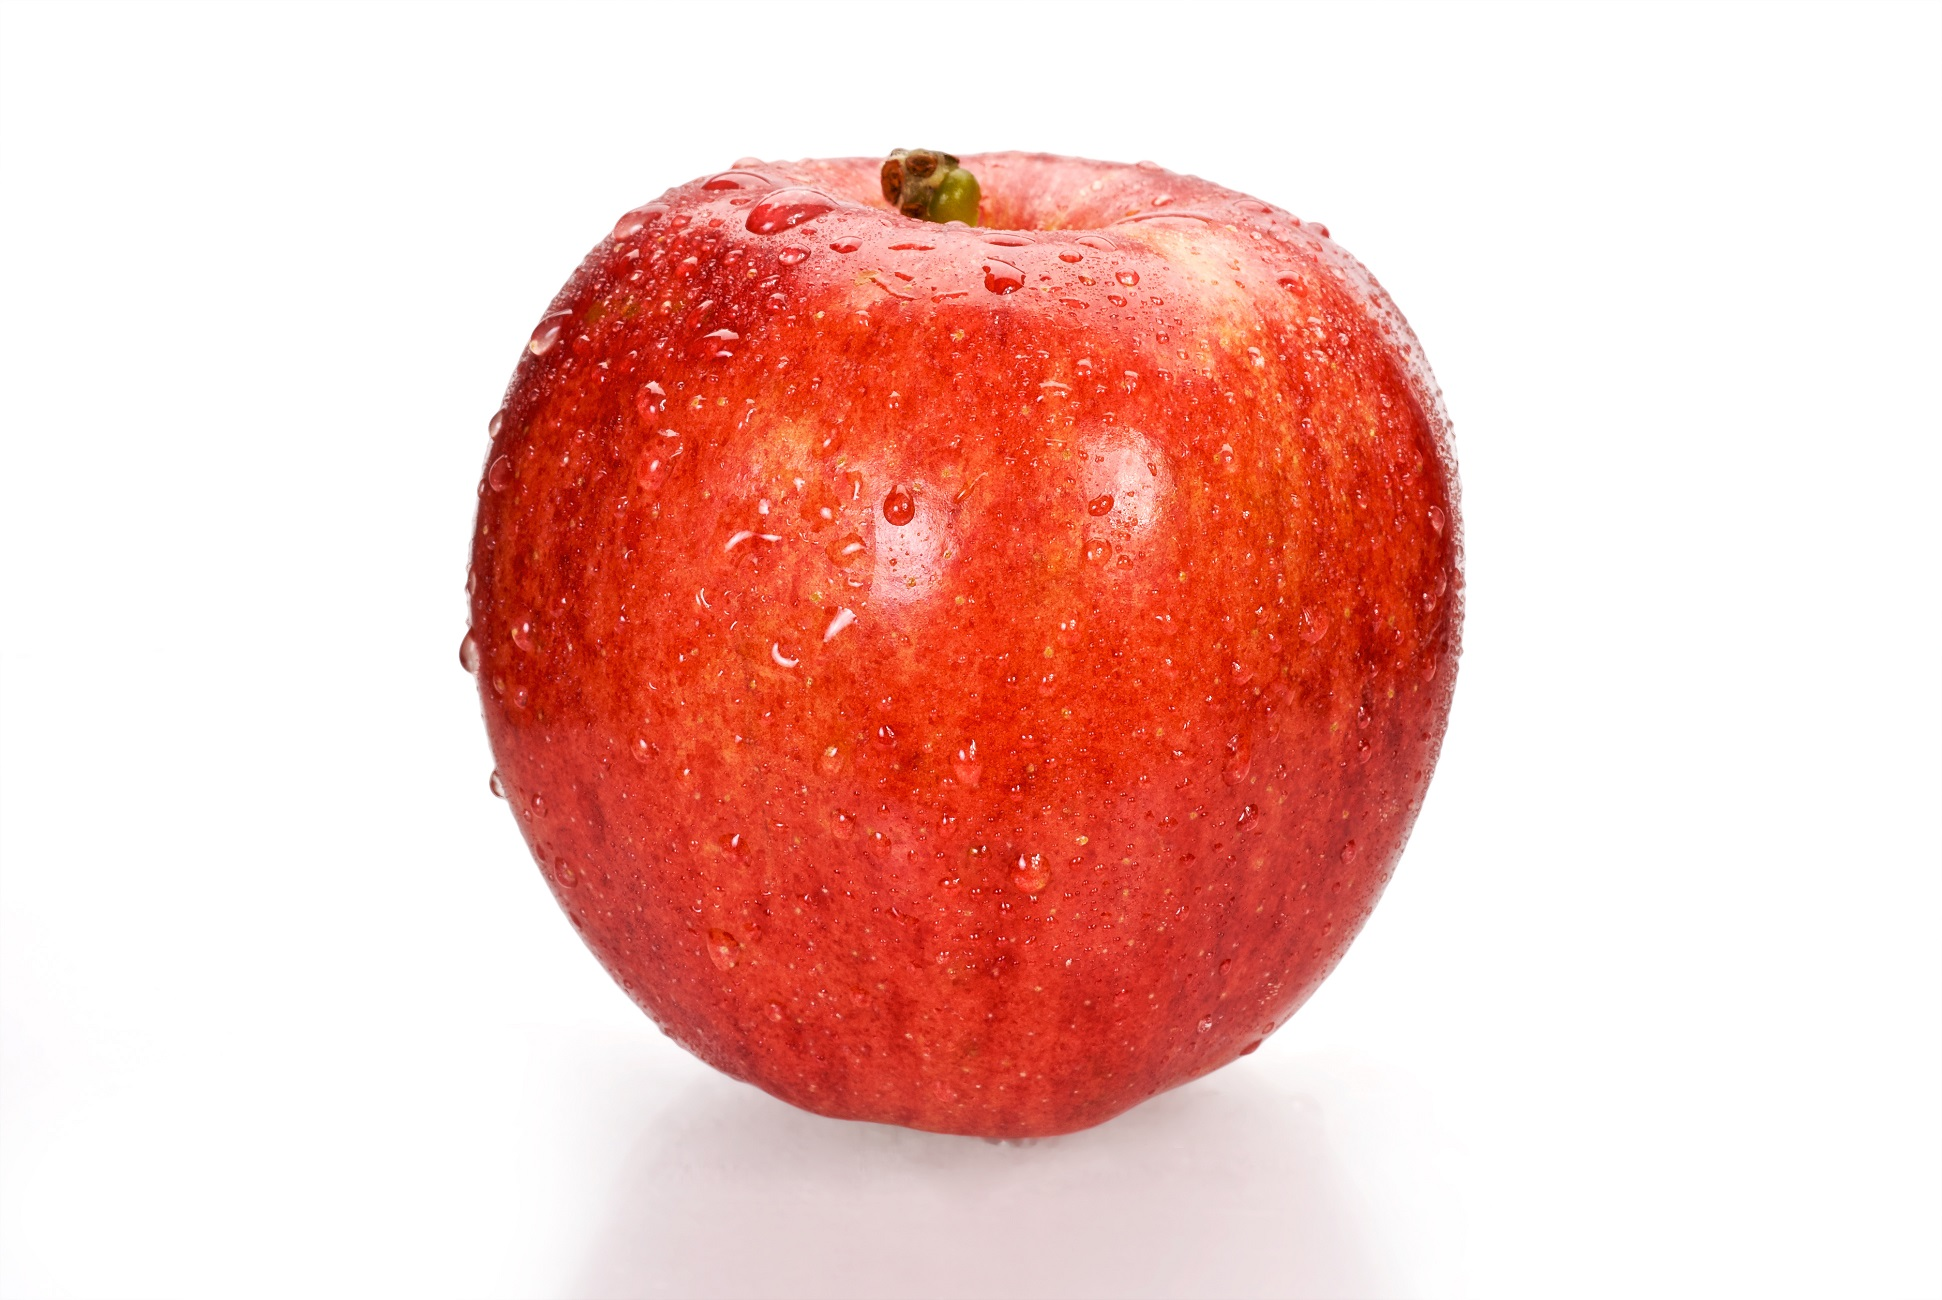

In [6]:
from azure.search.documents.models import VectorizableImageBinaryQuery
import requests
import base64

url = "https://upload.wikimedia.org/wikipedia/commons/c/c1/Fuji_apple.jpg"
response = requests.get(url)
base64_content = base64.b64encode(response.content).decode("utf-8")
vector_query = VectorizableImageBinaryQuery(base64_image=base64_content, k_nearest_neighbors=1, fields="embedding")  

# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["metadata_storage_path"],
    top=1
)   
  
print("Source Image")
display(Image(url=url))
# Print the search results  
for result in results:  
    print(f"Image: {os.path.basename(result['metadata_storage_path'])}") 
    display(Image(filename=os.path.join(apples_image_directory, os.path.basename(result['metadata_storage_path'])))) 
    print("\n") 